In [ ]:
import os
import time
import cv2

In [ ]:
path_to_images = os.path.join('data','images')
images_taken = 4

In [ ]:
cap = cv2.VideoCapture(0)
for num in range(images_taken):
    print('Snapping image {}'.format(num))
    ret, frame = cap.read()
    image_name = os.path.join(path_to_images, '.jpg')
    cv2.imwrite(image_name, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
gpu_list = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpu_list:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
images = tf.data.Dataset.list_files('/content/images_data/images/*.jpg')

In [ ]:
images.as_numpy_iterator().next()

b'/content/images_data/images/2023-05-08-112104_1.jpg'

In [ ]:
def get_image(x):
  # returns a byte-encoded image
  byte_img = tf.io.read_file(x)

  # we decode the image and return it
  return tf.io.decode_jpeg(byte_img)

In [ ]:
images = images.map(get_image)

In [ ]:
#images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [ ]:
# returns "batch_size" number of images
image_getter = images.batch(5).as_numpy_iterator()

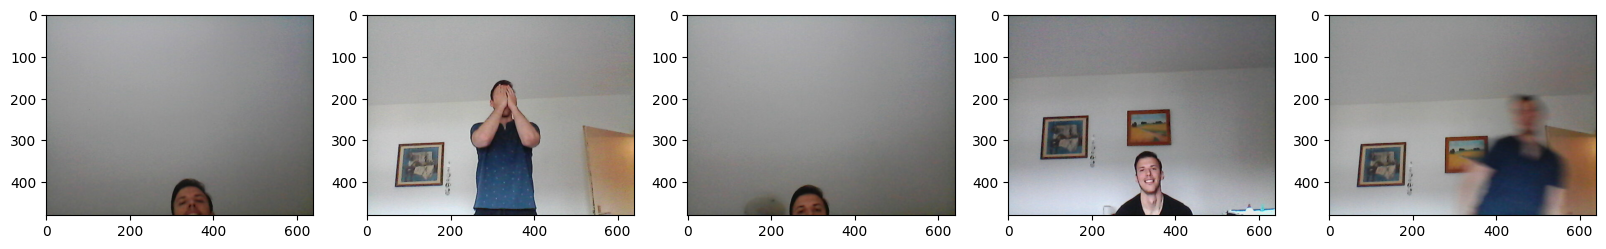

In [ ]:
show_images = image_getter.next()

fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(show_images):
  ax[idx].imshow(image)
plt.show()

In [ ]:
# Splitting the data to train, test, and validation partitions
# 60 to train, 16 to test, 16 to validation
# Done the splitting manually to ensure there is a proper variety of pictures in each partition

In [ ]:
for path in ['train', 'test', 'validation']:
  for file in os.listdir(os.path.join('/content/images_data', path, 'images')):
    file_name = file.split('.')[0] + '.json'
    label_filepath = os.path.join('/content/images_data', 'labeled_images', file_name)

    if os.path.exists(label_filepath):
      new_filepath = os.path.join('/content/images_data', path, 'labeled_images', file_name)
      os.replace(label_filepath, new_filepath)

In [ ]:
import albumentations as alb

In [ ]:
#image = cv2.imread(os.path.join('/content/images_data', 'images', '2023-05-08-111351_4.jpg'))

#image.shape

(480, 640, 3)

In [ ]:
image_augmentation = alb.Compose([alb.HorizontalFlip(p=0.5),
                                  alb.VerticalFlip(p=0.5),
                                  alb.RandomBrightnessContrast(p=0.2),
                                  alb.RGBShift(p=0.2),
                                  alb.RandomGamma(p=0.2),
                                  alb.RandomCrop(width=450, height=450)],
                                 bbox_params=alb.BboxParams(format='albumentations',
                                                  label_fields=['class_labels']))

In [ ]:
rand_image = cv2.imread(os.path.join('/content/images_data', 'train', 'images', '2023-05-08-112546_4.jpg'))

In [ ]:
with open(os.path.join('/content/images_data', 'train', 'labeled_images', '2023-05-08-112546_4.json'), 'r') as f:
  image_label = json.load(f)

In [ ]:
image_label['shapes']

[{'label': 'Face :)',
  'points': [[324.1062801932367, 478.6473429951691],
   [218.79227053140102, 367.536231884058]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [ ]:
coordinates = [0,0,0,0]

coordinates[0] = image_label['shapes'][0]['points'][0][0]
coordinates[1] = image_label['shapes'][0]['points'][0][1]
coordinates[2] = image_label['shapes'][0]['points'][1][0]
coordinates[3] = image_label['shapes'][0]['points'][1][1]

coordinates

[324.1062801932367, 478.6473429951691, 218.79227053140102, 367.536231884058]

In [ ]:
coordinates = list(np.divide(coordinates, [640,480,640,480]))

coordinates

[0.5064160628019324,
 0.9971819645732689,
 0.3418629227053141,
 0.7657004830917875]

In [ ]:
tmp1 = coordinates[0]
tmp2 = coordinates[1]
coordinates[0] = coordinates[2]
coordinates[2] = tmp1

coordinates[1] = coordinates[3]
coordinates[3] = tmp2

In [ ]:
coordinates

[0.3418629227053141,
 0.7657004830917875,
 0.5064160628019324,
 0.9971819645732689]

In [ ]:
augmented_image = image_augmentation(image=rand_image, bboxes=[coordinates], class_labels=['Face :)'])

In [ ]:
augmented_image['bboxes']

[(0.36620504562533557, 0.0, 0.6002361782071928, 0.24103059581320446)]

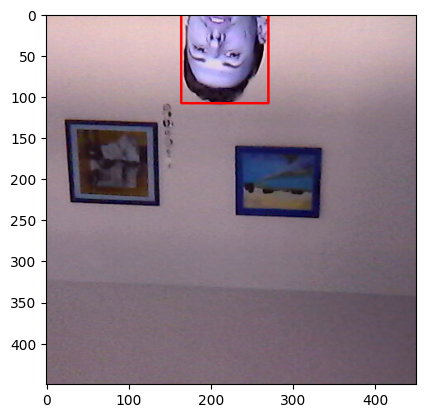

In [ ]:
cv2.rectangle(augmented_image['image'],
              tuple(np.multiply(augmented_image['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented_image['bboxes'][0][2:], [450,450]).astype(int)),
                    (255,0,0), 2)

plt.imshow(augmented_image['image'])